In [1]:
%matplotlib inline

In [2]:
import adolc

In [3]:
from adapt_utils.case_studies.tohoku.options import TohokuOkadaOptions
from adapt_utils.misc import taylor_test

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

# Inverting the Okada model

In this notebook, $\mathbf m$ contains parameters associated with an Okada function representation on an array of subfaults.
That is, the initial surface elevation $\eta_0$ is given by

$$
    \eta_0(\mathbf x)=\mathrm{Okada}(\mathbf m),
$$

where $\mathrm{Okada}$ denotes the Okada model.

We can use `pyadolc` to differentiate through the Okada model, giving

$$
    \frac{\mathrm d\eta_0}{\mathrm d\mathrm m}\:\widetilde{\mathrm m},
$$

for some choice of control parameters, $\widetilde{\mathrm m}$.
With an appropriate choice of seed vectors (i.e. a seed matrix), we can obtain the gradient

$$
    \frac{\mathrm d\eta_0}{\mathrm d\mathrm m}.
$$

(See previous notebook for details.)
Henceforth let's drop the subscript zero and instead use $\eta_{ij}$ to indicate the $(i,j)^{th}$ entry on the Okada grid.

Suppose we have a source field $\eta^\star$.
We would like to establish Okada parameters $\mathbf m$ so that $\mathrm{Okada}(\mathbf m)\approx\eta^\star$.
One approach is to solve an optimisation problem of the form

$$
    \min J(\eta;\mathbf m)\quad\text{such that}\quad\eta=\mathrm{Okada}(\mathbf m),
$$

where $J$ quantifies how well $\eta$ matches $\eta^\star$ in some sense.
We opt for the mean square error as our error measure:

$$
    J(\eta;\mathbf m)=\frac1{N^2}\sum_{i=0}^{N-1}\sum_{j=0}^{N-1}(\eta_{ij}-\eta_{ij}^\star)^2.
$$

where the Okada grid has dimensions $N\times N$.

There are potentially redundancies in the Okada source model in the sense that very similar fields can be generated using different combinations of the input parameters.
If so then there could be uniqueness/local minima issues when applying gradient-based optimisation routines.
This notebook explores whether or not we need to worry.

### Initialisation

Set parameters and create a `TohokuOkadaOptions` object to hold them.
Apply the Okada model with default input parameters to give the field we want to invert for, stored in memory as `eta`.

In [5]:
kwargs = {
    'okada_grid_resolution': 51,
    'debug': False,
}
plotting_kwargs = {
    'cmap': 'coolwarm',
    'levels': 50,
}
nonlinear = False

In [6]:
op = TohokuOkadaOptions(**kwargs)
op.create_topography()
N = op.N
X = op.fault.dtopo.X
Y = op.fault.dtopo.Y
eta = op.fault.dtopo.dZ.copy()
m_orig = op.get_input_vector()
np.save("notebook_4_m_orig", m_orig)

### Differentatiate the source model

Perturb the control parameters with some Normal random noise so that the source is different from that used to generate the gauge timeseries data.
This effectively means 'choose an initial guess'.

In [7]:
kwargs['control_parameters'] = op.control_parameters
for control in op.active_controls:
    size = np.shape(op.control_parameters[control])
    kwargs['control_parameters'][control] += np.random.normal(loc=0, scale=10, size=size)

When setting the free surface initial condition using the Okada model, we tell `pyadolc` to annotate its tape.
For this application we need to modify the way that the tape is annotated by default.

In [8]:
class TohokuOkadaInversionOptions(TohokuOkadaOptions):
    """
    A subclass of :class:`TohokuOkadaOptions` which adds an extra step to the annotation. Namely, the mean
    square error between the computed surface and the 'true solution' is computed by looping over the vertices
    of the Okada grid.
    """
    
    def _create_topography_active(self, tag=0, separate_faults=False):
        
        # Sanitise kwargs
        assert isinstance(tag, int)
        assert tag >= 0
        for control in self.active_controls:
            assert control in self.all_controls
        
        # Initialise tape
        adolc.trace_on(tape_tag)

        # Read parameters and mark active variables as independent
        msg = "Subfault {:d}: shear modulus {:4.1e} Pa, seismic moment is {:4.1e}"
        for i, subfault in enumerate(self.subfaults):
            for control in self.all_controls:
                if control in self.active_controls:
                    subfault.__setattr__(control, adolc.adouble(self.control_parameters[control][i]))
                    adolc.independent(subfault.__getattribute__(control))
                else:
                    subfault.__setattr__(control, self.control_parameters[control][i])
            self.print_debug(msg.format(i, subfault.mu, subfault.Mo().val))

        # Create the topography, thereby calling Okada
        self.print_debug("SETUP: Creating topography using Okada model...")
        self.fault.create_dtopography(verbose=self.debug, active=True)
        self.print_debug("SETUP: Done!")

        # Compute quantity of interest
        self.J_subfaults = [0.0 for j in range(self.N)]
        for j in range(self.N):
            for i in range(self.N):
                self.J_subfaults[j] += (eta[i, j] - self.fault.dtopo.dZ_a[i, j])**2
            self.J_subfaults[j] /= op.N**2

        self.J = sum(self.J_subfaults)
            
        # Mark dependence
        if separate_faults:
            for j in range(self.N):
                adolc.dependent(self.J_subfaults[j])
        else:
            adolc.dependent(self.J)
        adolc.trace_off()

Create the topography once in order to annotate the tape

In [9]:
tape_tag = 0
op = TohokuOkadaInversionOptions(**kwargs)
op.create_topography(annotate=True, tag=tape_tag)
op.get_seed_matrices()  # these can be reused over and over
print("QoI = {:.4e}".format(op.J.val))

QoI = 5.8582e-01


Create some arrays to keep track of the optimisation routine

In [10]:
op.J_progress = []
op.dJdm_progress = []

Sum over all subfaults to get the total QoI.
By unrolling the tape, we can easily express the reduced functional as a function of the active controls.
Note that we raise a flag which prepares for a subsequent reverse mode propagation.

In [11]:
def reduced_functional(m):
    """Apply the Okada model by unrolling the tape and compute the QoI."""
    J = sum(adolc.zos_forward(tape_tag, m, keep=1))
    op.J_progress.append(J)
    return J

In [12]:
J = reduced_functional(op.input_vector)
assert np.isclose(J, op.J.val)

The reverse mode of AD computes

$$
    \mathbf m_b:=\frac{\mathrm dJ}{\mathrm d\mathbf m}^T\:J_b,
$$

where $J_b$ is a scalar *seed* and $\mathbf m_b$ is of the same dimension as the control parameter vector.
Therefore we can propagate through the reverse mode of AD to get the gradient by choosing a unit seed.

In [13]:
def gradient(m):
    """Compute the gradient of the QoI with respect to the input parameters."""
    dJdm = adolc.fos_reverse(tape_tag, 1.0)
    norm = np.linalg.norm(dJdm)
    op.dJdm_progress.append(norm)
    return dJdm

In [14]:
g = gradient(op.input_vector)
assert len(g) == len(op.input_vector)
print("J = {:.4e}  ||dJdm|| = {:.4e}".format(op.J_progress[-1], op.dJdm_progress[-1]))

J = 5.8582e-01  ||dJdm|| = 1.5562e-02


In [15]:
eta_pert = op.fault.dtopo.dZ.copy()

Check that the function stored to tape evaluates as it should

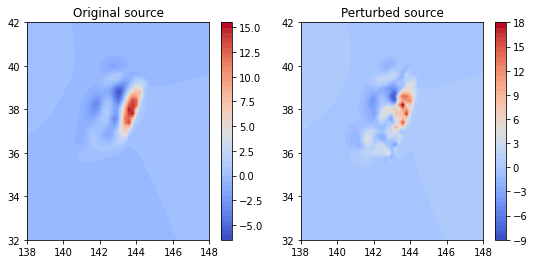

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4))
eta_pert = op.fault.dtopo.dZ.reshape(N, N)
fig.colorbar(axes[0].contourf(X, Y, eta, **plotting_kwargs), ax=axes[0]);
axes[0].set_title("Original source");
fig.colorbar(axes[1].contourf(X, Y, eta_pert, **plotting_kwargs), ax=axes[1]);
axes[1].set_title("Perturbed source");

### Taylor test

Before attempting gradient-based optimisation, we better check that our gradient function is consistent.

In [17]:
taylor_test(reduced_functional, gradient, op.input_vector, verbose=True)

========================TAYLOR TEST========================
h = 1.0000e+00
Taylor remainder = 8.6057e-03
h = 5.0000e-01
Taylor remainder = 2.1625e-03
h = 2.5000e-01
Taylor remainder = 5.4188e-04
====================TAYLOR TEST PASSED!====================


### Inversion

Now we are ready to do the gradient-based optimisation.
Here we use BFGS and require that the gradient norm is smaller than $10^{-8}$ for convergence.

In [18]:
# Reset progress arrays
op.J_progress = []
op.dJdm_progress = []

def opt_cb(m):
    """Print progress after every successful line search"""
    msg = "{:4d}: J = {:.4e}  ||dJdm|| = {:.4e}"
    counter = len(op.J_progress)
    if counter % 100 == 0:
        print(msg.format(counter, op.J_progress[-1], op.dJdm_progress[-1]))

opt_parameters = {
    'maxiter': 40000,
    'disp': True,
    'gtol': 1.0e-08,
    'callback': opt_cb,
    'retall': True,
    'fprime': gradient,
}

m_opt, out = scipy.optimize.fmin_bfgs(reduced_functional, op.input_vector, **opt_parameters)

 100: J = 2.0814e-02  ||dJdm|| = 8.9802e-04
 200: J = 3.7157e-03  ||dJdm|| = 3.7106e-04
 300: J = 1.3759e-03  ||dJdm|| = 1.9983e-04
 400: J = 5.9656e-04  ||dJdm|| = 5.7884e-05
 500: J = 2.7309e-04  ||dJdm|| = 4.8027e-05
 600: J = 1.7000e-04  ||dJdm|| = 3.7049e-05
 700: J = 1.1354e-04  ||dJdm|| = 2.0918e-05
 800: J = 8.0667e-05  ||dJdm|| = 1.1556e-05
 900: J = 5.7101e-05  ||dJdm|| = 7.8217e-06
1000: J = 4.0397e-05  ||dJdm|| = 1.0131e-05
1100: J = 3.0475e-05  ||dJdm|| = 8.3822e-06
1200: J = 2.4501e-05  ||dJdm|| = 9.0274e-06
1300: J = 1.9127e-05  ||dJdm|| = 6.0919e-06
1400: J = 1.6678e-05  ||dJdm|| = 4.7030e-06
1500: J = 1.4237e-05  ||dJdm|| = 2.5033e-06
1600: J = 1.2412e-05  ||dJdm|| = 2.5164e-06
1700: J = 1.1041e-05  ||dJdm|| = 2.9393e-06
1800: J = 9.6742e-06  ||dJdm|| = 2.9685e-06
1900: J = 8.3498e-06  ||dJdm|| = 2.9473e-06
2000: J = 7.4208e-06  ||dJdm|| = 1.8642e-06
2100: J = 6.4189e-06  ||dJdm|| = 1.9954e-06
2200: J = 5.5753e-06  ||dJdm|| = 1.6111e-06
2300: J = 4.9093e-06  ||dJdm|| =

In [19]:
np.save("notebook_4_m_opt", m_opt)

Let's take a look at the progress of the reduced functional and gradient

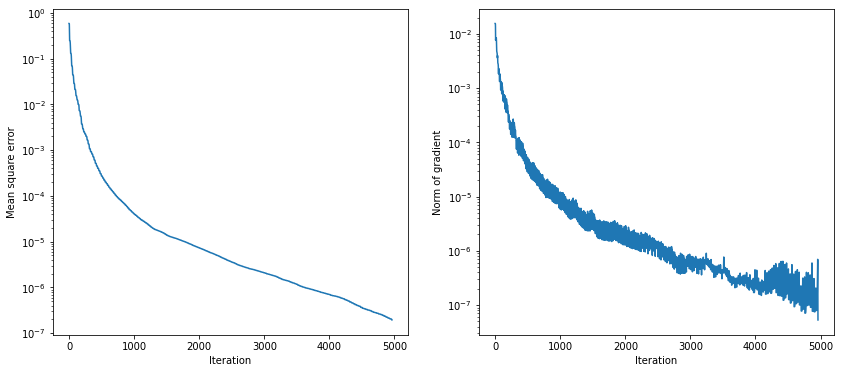

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

ax = axes[0]
ax.semilogy(op.J_progress);
ax.set_xlabel("Iteration");
ax.set_ylabel("Mean square error");

ax = axes[1]
ax.semilogy(op.dJdm_progress);
ax.set_xlabel("Iteration");
ax.set_ylabel("Norm of gradient");

Compare the optimised parameters, `m_opt`, against the original ones, `m_orig`.

In [21]:
diff = m_opt - m_orig
print("Mean square error of controls = {:.4e}".format(np.linalg.norm(diff)**2/len(m_opt)))

Mean square error of controls = 6.0931e+01


In [22]:
diff = diff.reshape(op.nx*op.ny, len(op.active_controls))
for j, row in enumerate(diff):
    print("{:3d}: {:8.4f}, {:8.4f}, {:8.4f}, {:8.4f}".format(j, *row))

  0:   0.0126,   7.6367,  -4.9739,  -4.2888
  1:  -0.1743,   2.2919,   2.1858,   0.6055
  2:  -0.2301,  11.4393,   4.2869,  -0.0104
  3:   1.3245,   5.5175,  -4.8969,  -0.6080
  4:   1.8223,  -3.4865,  -1.0391,   1.0566
  5:  -3.9923,  -0.1693,   0.7856,  -3.1218
  6:   1.6254,   1.8395,  -2.2518,   0.2475
  7:  -4.3383,  -7.8634,  -6.0011,  -1.4731
  8:  -2.6455,  -1.1383,   0.3599,   0.4592
  9:   1.9187,   5.1537,  -0.3385,   1.9691
 10:  -1.1220,   3.3815,   7.3718,  -0.4623
 11:   0.2401,   3.4030,  -7.5112,  -1.2711
 12:  -3.2370,   0.6674,  20.0077,   0.7080
 13:  -0.2244,  16.6984,   0.2255,   0.1733
 14:   1.6582,   8.3509,  -5.9535,   0.9556
 15:  -0.0880,   4.5554,  -9.2823,   1.4461
 16:   0.0230,   9.4304, -16.1542, -14.3738
 17:  -0.0245, -11.4482,  -9.7629,   5.1262
 18:  -0.0095,   7.6645,  -6.0845,  -9.8636
 19:   0.0949,  14.1171,   2.6683,  22.5588
 20:   0.2807,  -9.6144,  -7.2377,   3.9014
 21:   0.2694, -12.7809,  -7.6734,  -0.3115
 22:  -3.8137,  -4.7485,   4.946

In [23]:
msg = "Maximum pointwise difference: {:.4f} degree difference in {:s} on subfault {:d}"
loc = np.unravel_index(np.argmax(diff, axis=None), diff.shape)
print(msg.format(diff[loc], op.active_controls[loc[1]], loc[0]))

Maximum pointwise difference: 27.6900 degree difference in rake on subfault 182


In [7]:
m_opt = np.load("notebook_4_m_opt.npy")
m_opt = m_opt.reshape(op.nx*op.ny, len(op.active_controls))
for i, control in enumerate(op.active_controls):
    op.control_parameters[control] = m_opt[:, i]

In [8]:
op.create_topography()

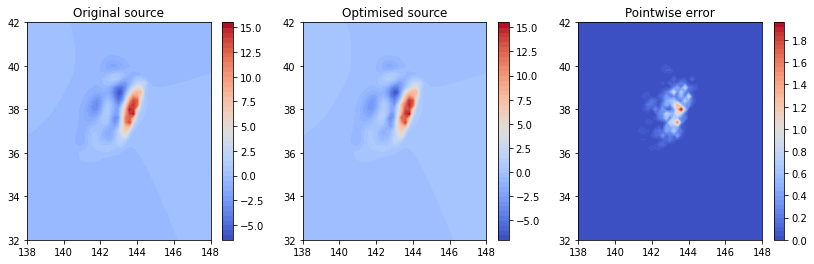

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 4))
eta_pert = op.fault.dtopo.dZ.reshape(N, N)
fig.colorbar(axes[0].contourf(X, Y, eta, **plotting_kwargs), ax=axes[0]);
axes[0].set_title("Original source");
fig.colorbar(axes[1].contourf(X, Y, eta_pert, **plotting_kwargs), ax=axes[1]);
axes[1].set_title("Optimised source");
fig.colorbar(axes[2].contourf(X, Y, np.abs(eta - eta_pert), **plotting_kwargs), ax=axes[2]);
axes[2].set_title("Pointwise error");